# 使用 Keras 進行花朵辨識
本範例輸出期末考的 CNN baseline 預測, 提供同學參考

In [1]:
import tensorflow as tf
import numpy as np
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

config = tf.ConfigProto()

/opt/intel/intelpython3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# 先來看看訓練資料下有那些目錄吧
import os
train_path = 'game01/kaggle_final/input/train/'
test_path = 'game01/kaggle_final/input/test/'
print(os.listdir(train_path))

['dandelion', 'sunflower', 'rose', 'tulip', 'daisy']


# 1. 載入套件

In [3]:
# 載入基礎套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 繪圖設定
from matplotlib import style
%matplotlib inline  
style.use('fivethirtyeight')

# 設定忽略警告訊息
import warnings
warnings.filterwarnings('ignore')

In [4]:
# 載入 Keras 預處理套件 - ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator

# 載入 Keras 其他深度學習套件
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, Conv2D, MaxPooling2D
from keras.optimizers import Adam
#from keras.callbacks import ReduceLROnPlateau # 作用 : 當監控的目標值停止改善時, 開始降低學習速率
from keras.utils import to_categorical # Keras 做 One Hot Encoding 的函數

Using TensorFlow backend.


In [5]:
# 其他相關套件    
import tensorflow as tf
import random as rn
import cv2 
from tqdm import tqdm # 進度條顯示套件  

# 2. 資料預處理

In [6]:
IMAGE_SIZE = (240, 320)
BATCH_SIZE = 32

# 設定花朵名稱對應的類別碼
flower_mapping = {'daisy':0, 'dandelion':1, 'rose':2, 'sunflower':3, 'tulip':4}
flowers = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input

In [8]:
# 設定輸入的 train / test 資料流
datagen = ImageDataGenerator(    
    rotation_range=10, #隨機旋轉角度的上限 (角度值 : 0 ~ 180)
    width_shift_range=0.2, # 左右隨機平移上限
    height_shift_range=0.2, # 上下隨機平移上限
    shear_range=0.2, # 逆時針的剪切變形角度
    zoom_range=0.2, # 影像倍率放大縮小的上限
    horizontal_flip=True, # 是否左右翻轉
    fill_mode='nearest', # 填補周圍空缺方法
    validation_split=0.2, # 測試集採樣比
    preprocessing_function=preprocess_input) # 資料前處理

In [9]:
train_generator = datagen.flow_from_directory(train_path, target_size=(240, 320), classes=flowers, 
                                                    batch_size=BATCH_SIZE, subset='training') # 設為訓練集
valid_generator = datagen.flow_from_directory(train_path, target_size=(240, 320), classes=flowers, 
                                                    batch_size=BATCH_SIZE, subset='validation') # 設為驗證集         

Found 2260 images belonging to 5 classes.
Found 563 images belonging to 5 classes.


# 3. 設定模型與運算

In [10]:
import keras
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint 

In [11]:
# 使用 Keras Sequential 定義一個 CNN 模型
resnet = ResNet50(input_shape=(240, 320, 3), weights='imagenet', pooling='avg', include_top=False)
output = keras.layers.Dense(5, activation="softmax")(resnet.output)
model = Model(inputs=[resnet.input], outputs=[output])

In [12]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 320, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 246, 326, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 120, 160, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 120, 160, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [13]:
model.compile(optimizer=keras.optimizers.Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['acc'])

In [14]:
early_stopping = EarlyStopping(monitor='val_acc', patience=30)
model_checkpoint = ModelCheckpoint("game01/kaggle_final/best_model.h5", save_best_only=True)

In [15]:
history = model.fit_generator(train_generator, steps_per_epoch=train_generator.samples // BATCH_SIZE,
                              epochs=100,
                              validation_data=valid_generator, validation_steps=valid_generator.samples // BATCH_SIZE,
                              use_multiprocessing=True,
                              workers=8, callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
70/70 [==============================] - 32s 457ms/step - loss: 0.7985 - acc: 0.7821 - val_loss: 0.8109 - val_acc: 0.6930
Epoch 2/100
70/70 [==============================] - 16s 229ms/step - loss: 0.4667 - acc: 0.8616 - val_loss: 0.3129 - val_acc: 0.9007
Epoch 3/100
70/70 [==============================] - 16s 227ms/step - loss: 0.2824 - acc: 0.9272 - val_loss: 0.2460 - val_acc: 0.8971
Epoch 4/100
70/70 [==============================] - 16s 227ms/step - loss: 0.2215 - acc: 0.9433 - val_loss: 0.3470 - val_acc: 0.8787
Epoch 5/100
70/70 [==============================] - 16s 229ms/step - loss: 0.1959 - acc: 0.9446 - val_loss: 0.3659 - val_acc: 0.8879
Epoch 6/100
70/70 [==============================] - 16s 229ms/step - loss: 0.1569 - acc: 0.9585 - val_loss: 0.2713 - val_acc: 0.8989
Epoch 7/100
70/70 [==============================] - 16s 229ms/step - loss: 0.1142 - acc: 0.9741 - val_loss: 0.3854 - val_acc: 0.8842
Epoch 8/100
70/70 [==============================] - 16s 234ms

In [21]:
best_model = keras.models.load_model("game01/kaggle_final/best_model.h5")

In [22]:
import glob
from PIL import Image

In [18]:
data = np.array([cv2.resize(np.array(cv2.imread(x)[:,:,::-1]), (320,240)) for x in sorted(glob.glob('game01/kaggle_final/input/test/*.jpg'))])
data = preprocess_input(data)

In [23]:
y_pred = best_model.predict(data)

In [24]:
from sklearn.metrics import accuracy_score

In [25]:
df = pd.read_csv("game01/kaggle_final/final_Ans.csv")

In [26]:
accuracy_score(df['flower_class'], np.argmax(y_pred, 1))

0.9415

# 4. 訓練結果影像化, 並輸出預測

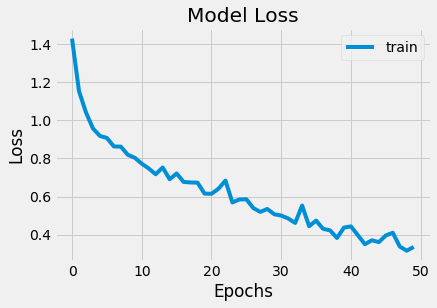

In [17]:
# 顯示訓練集的 Loss 結果
plt.plot(History.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train'])
plt.show()

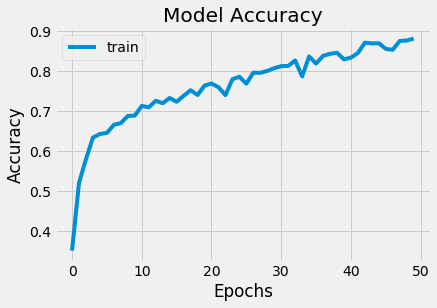

In [18]:
# 顯示訓練集的 Accuracy 結果
plt.plot(History.history['acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train'])
plt.show()

In [19]:
# 輸出預測檔
pred = model.predict(X_test)
pred_digits = np.argmax(pred, axis=1)
sub = pd.DataFrame({'id': id_test, 'flower_class': pred_digits})
sub.to_csv('flower_CNN.csv', index = False)